# Mixture density network - mixture of betas

## Import libraries

In [1]:
import numpy as np
import tensorflow as tf
import edward as ed
import matplotlib.pyplot as plt

from edward.models import Mixture, Categorical, Normal
from keras.layers import Dense
from scipy import stats
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


## Input parameters

In [2]:
N = 5000  # Number of data points
D = 1     # Number of features
K = 10    # Number of mixture components

## Build dataset

In [3]:
def build_toy_dataset(N):
    y_data = np.random.uniform(-10.5, 10.5, N)
    r_data = np.random.normal(size=N)  # random noise
    x_data = np.sin(0.75 * y_data) * 7.0 + y_data * 0.5 + r_data * 1.0
    x_data = x_data.reshape((N, 1))
    
    x_min = x_data.min()-0.00001
    x_max = x_data.max()+0.00001
    
    x_data = (x_data-x_min)/(x_max-x_min)
    
    y_min = y_data.min()-0.00001
    y_max = y_data.max()+0.00001
    
    y_data = (y_data-y_min)/(y_max-y_min)
    
    return train_test_split(x_data, y_data, test_size=0.25)

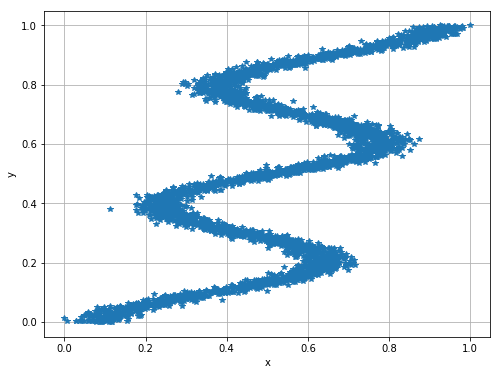

In [4]:
X_train, X_test, y_train, y_test = build_toy_dataset(N)
plt.figure(figsize=(8,6))
plt.plot(X_train, y_train, '*')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

In [5]:
X_train.shape

(3750, 1)

In [6]:
print("Size of features in training data: {}".format(X_train.shape))
print("Size of output in training data: {}".format(y_train.shape))
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))

Size of features in training data: (3750, 1)
Size of output in training data: (3750,)
Size of features in test data: (1250, 1)
Size of output in test data: (1250,)


## Build mixture density network

In [7]:
def neural_network_keras(X):
    h = Dense(units=32, activation='relu')(X)
    h = Dense(units=32, activation='relu')(h)
    h = Dense(units=32, activation='relu')(h)
    pis = Dense(units=K, activation='linear')(h)
    mus = Dense(units=K, activation='linear')(h)
    sigmas = Dense(units=K, activation=tf.exp)(h)
    
    return pis, mus, sigmas

In [8]:
X_ph = tf.placeholder(tf.float32, [None, D])
y_ph = tf.placeholder(tf.float32, [None])

In [9]:
pis, mus, sigmas = neural_network_keras(X_ph)
cat = Categorical(logits=pis)
components = []
components.extend([Normal(loc=mu, scale=sigma) for mu, sigma 
                   in zip(tf.unstack(tf.transpose(mus)),tf.unstack(tf.transpose(sigmas)))])
y = Mixture(cat=cat, components=components)

## Inference

In [10]:
inference = ed.MAP(data={y: y_ph})

optim = 'Adam'
if optim == 'Adam':
    optimizer = tf.train.AdamOptimizer(learning_rate=1e-3,
                                       beta1=0.9,
                                       beta2=0.999,
                                       epsilon=1e-08)
elif optim == 'RMSprop':
    optimizer = tf.train.RMSPropOptimizer(learning_rate=1e-3,
                                          decay=0.9,
                                          epsilon=1e-10)
    
inference.initialize(optimizer=optimizer, var_list=tf.trainable_variables())

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [11]:
sess = ed.get_session()
tf.global_variables_initializer().run()

In [12]:
n_epoch = 0
train_loss = np.array([])
test_loss = np.array([])

In [13]:
n_epoch_add = 1000
train_loss = np.concatenate((train_loss,np.zeros(n_epoch_add)))
test_loss = np.concatenate((test_loss,np.zeros(n_epoch_add)))
inference.n_print = 10
inference.progbar.target = n_epoch+n_epoch_add
for i in range(n_epoch,n_epoch+n_epoch_add):
    info_dict = inference.update(feed_dict={X_ph: X_train, y_ph: y_train})
    train_loss[i] = info_dict['loss']
    test_loss[i] = sess.run(inference.loss, feed_dict={X_ph: X_test, y_ph: y_test})
    inference.print_progress(info_dict)

n_epoch = n_epoch+n_epoch_add

1000/1000 [100%] ██████████████████████████████ Elapsed: 14s | Loss: -5426.616


## Plot training diagnostics

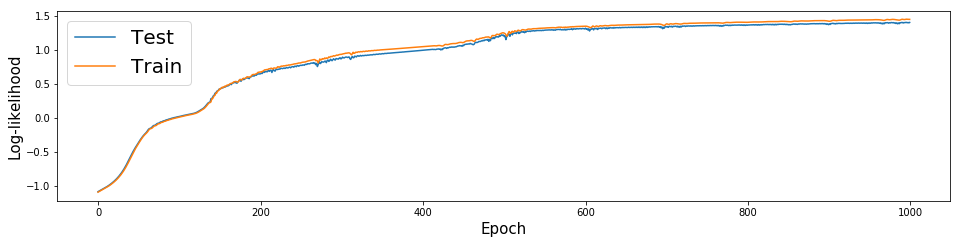

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(16, 3.5))
plt.plot(np.arange(n_epoch), -test_loss / len(X_test), label='Test')
plt.plot(np.arange(n_epoch), -train_loss / len(X_train), label='Train')
plt.legend(fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Log-likelihood', fontsize=15)
plt.show()

## Make prediction

In [15]:
pred_weights, pred_mus, pred_sigmas = sess.run([tf.nn.softmax(pis), mus, sigmas], feed_dict={X_ph: X_test})

In [16]:
N_x = 100
X_mean = np.linspace(0,1,N_x).reshape(-1,1)

In [17]:
pred_weights_mean, pred_mus_mean, _ = sess.run([tf.nn.softmax(pis), mus, sigmas], feed_dict={X_ph: X_mean})

## Plot result

### Plot distribution

In [18]:
def plot_normal_mix(pis, mus, sigmas, x_true, y_true, comp=True):
    fig, ax = plt.subplots(1,1,figsize=(16,6))
    y = np.linspace(0, 1, 1000)
    final = np.zeros_like(y)
    for i, (weight_mix, mu_mix, sigma_mix) in enumerate(zip(pis, mus, sigmas)):
        temp = weight_mix * stats.norm.pdf(y, mu_mix, sigma_mix)
        final = final + temp
        if comp:
            ax.plot(y, temp, label='beta ' + str(i))
    ax.plot(y, final, label='Mixture of betas')
    ax.axvline(x=y_true, color='k')
    ax.legend(fontsize=13)
    plt.title(str(x_true))

In [20]:
ns = [34, 45, 234, 342, 543, 567, 599, 645, 679, 750, 850, 940]

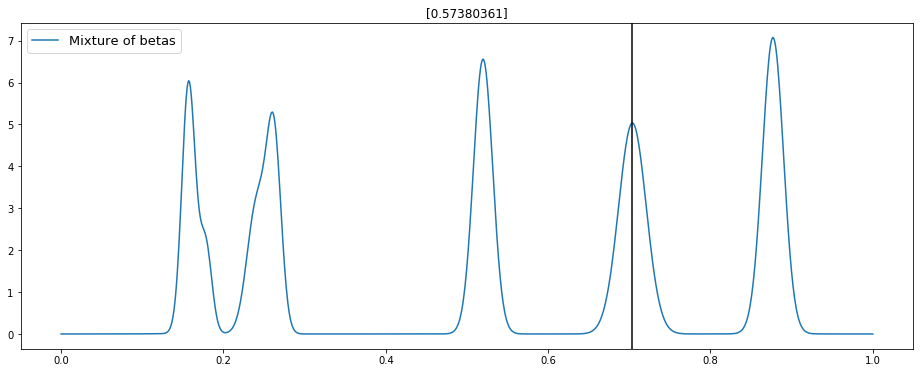

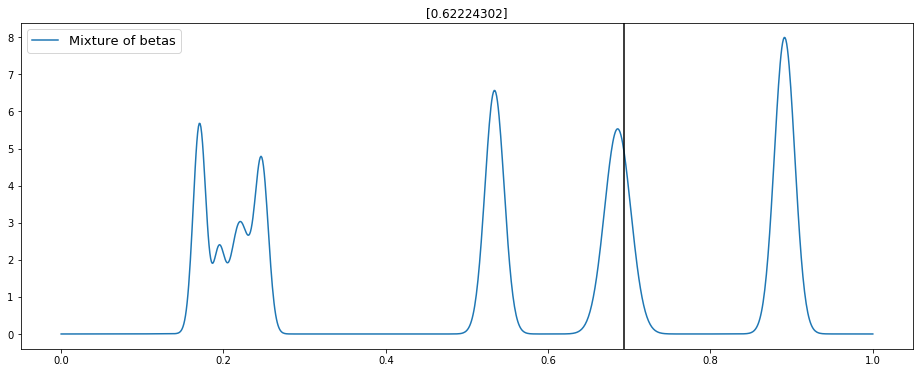

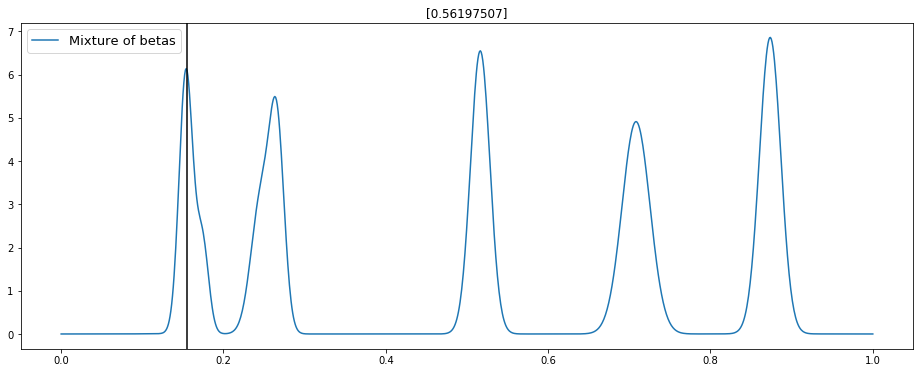

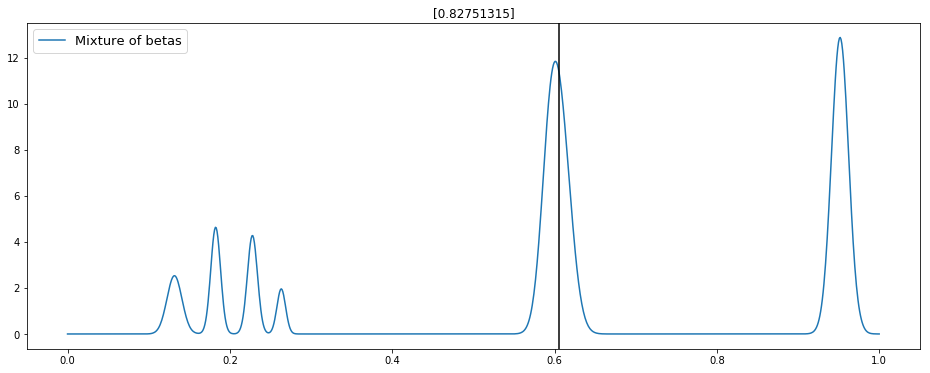

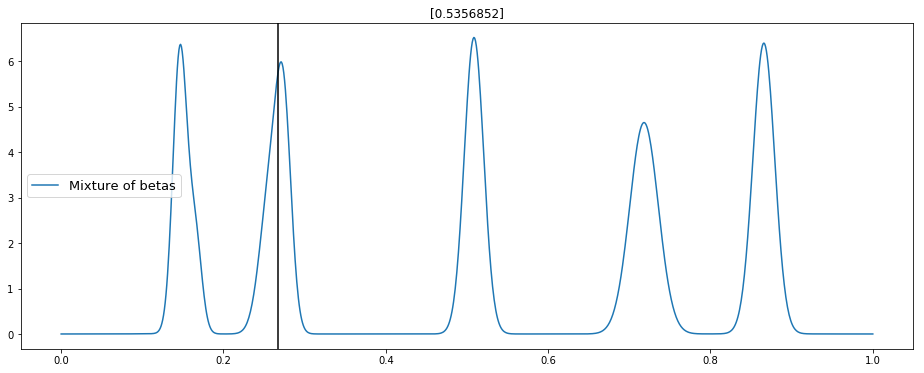

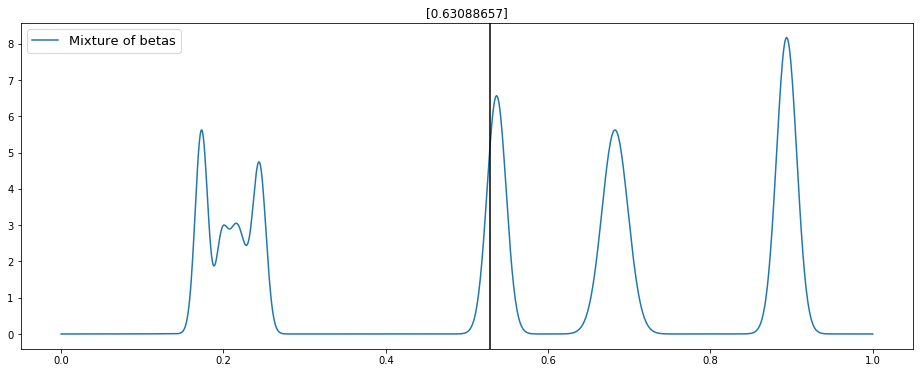

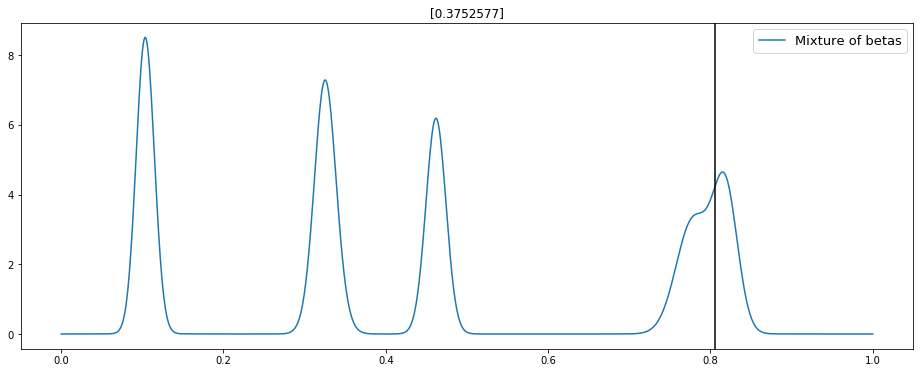

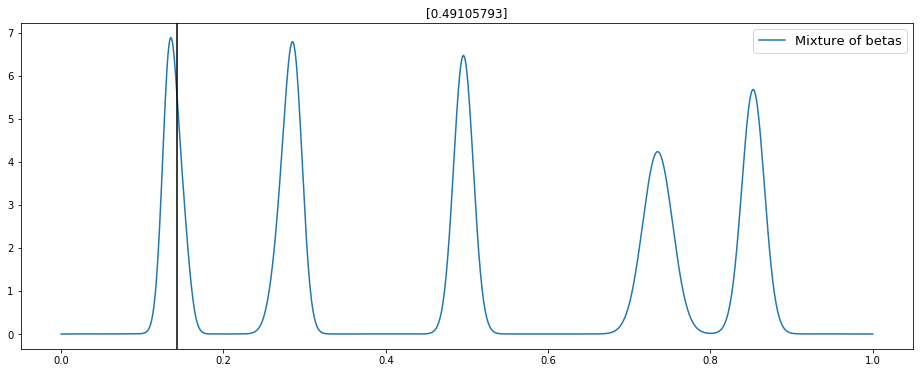

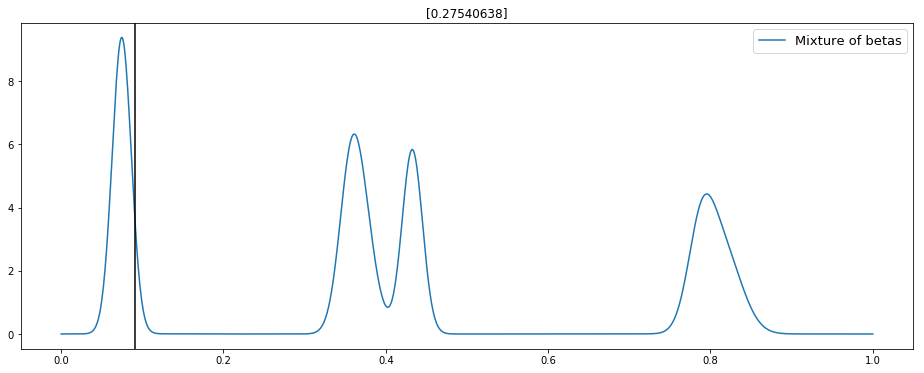

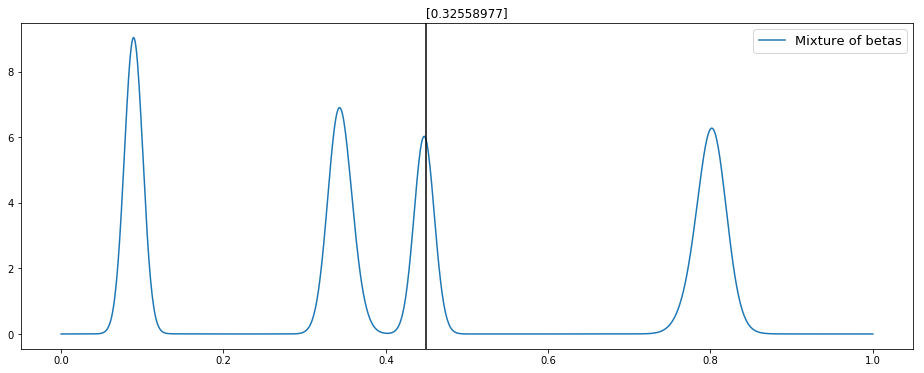

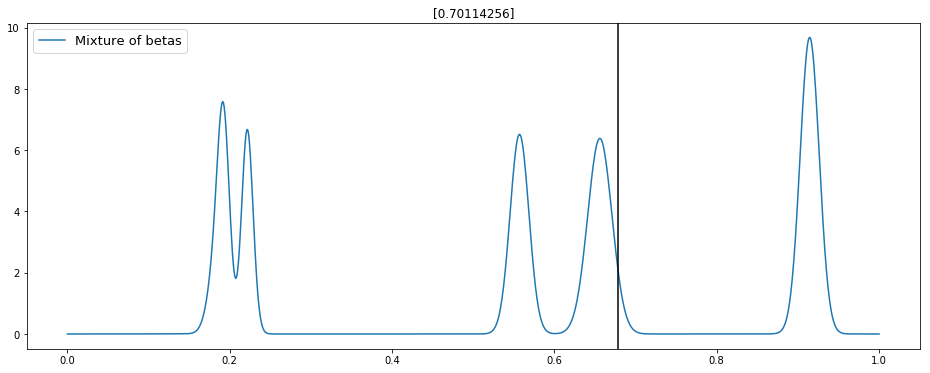

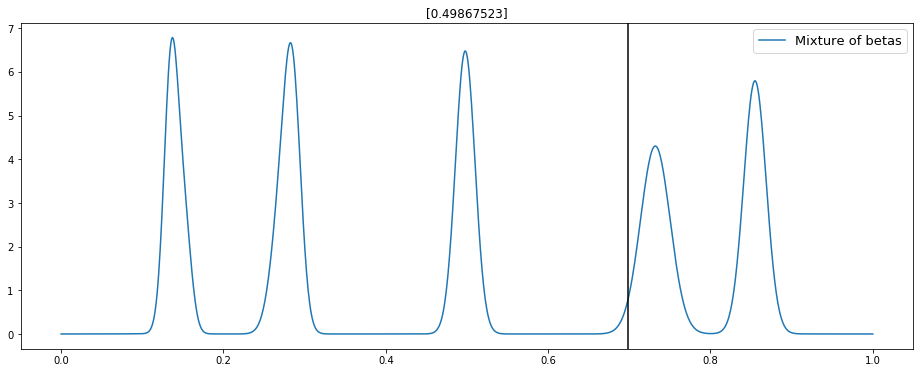

In [21]:
for n in ns: 
    plot_normal_mix(pred_weights[n,:], pred_mus[n,:], pred_sigmas[n,:], X_test[n], y_test[n], comp=False)

### Plot samples

In [22]:
def sample_from_mixture(x, pred_weights, pred_mus, pred_sigmas, amount):

    samples = np.zeros((amount, 2))
    n_mix = len(pred_weights[0])
    to_choose_from = np.arange(n_mix)
    for j, (weights, mus, sigmas) in enumerate(zip(pred_weights, pred_mus, pred_sigmas)):
        index = np.random.choice(to_choose_from, p=weights)
        samples[j, 1] = np.random.normal(mus[index], sigmas[index], size=1)
        samples[j, 0] = x[j]
        if j == amount - 1:
            break
        
    return samples

In [23]:
samples = sample_from_mixture(X_test, pred_weights, pred_mus, pred_sigmas, amount=len(X_test))

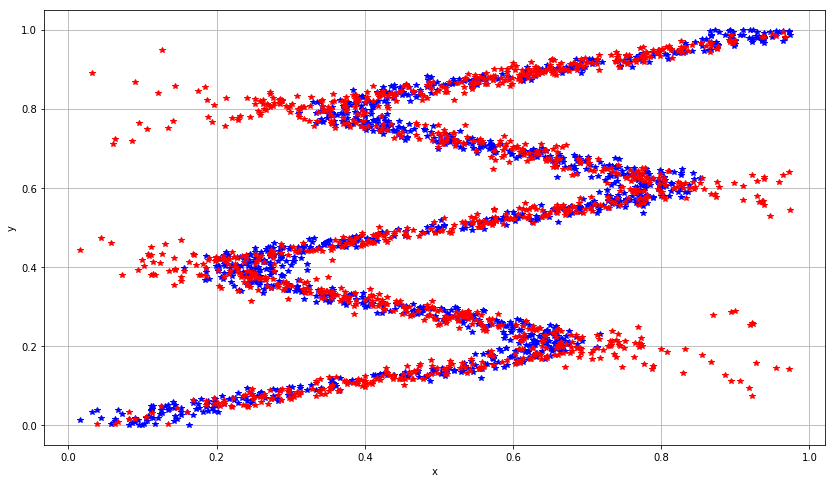

In [24]:
plt.figure(figsize=(14,8))
plt.plot(X_test, y_test,'b*')
plt.plot(samples[:,0], samples[:,1],'r*')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()

### Plot means

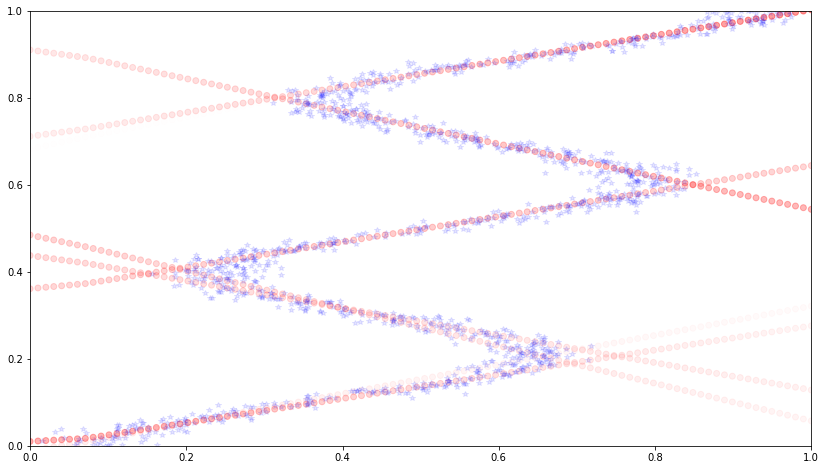

In [25]:
plt.figure(figsize=(14,8))
plt.plot(X_test, y_test, 'b*', alpha=0.1)
rgba_colors = np.zeros((N_x,4))
rgba_colors[:,0] = 1.0
for i in range(K):
    rgba_colors[:, 3] = pred_weights_mean[:,i]
    plt.scatter(X_mean,pred_mus_mean[:,i], color=rgba_colors)

plt.axis([0,1,0,1]);